# Clustering


# Manfaat

Perencanaan Pembangunan

# Dataset yang digunakan
https://www.kaggle.com/datasets/srikaranand/roadsegmentationfromsatelliteimagesdataset

In [1]:
# # Mengupload file dari komputer lokal
# from google.colab import files
# files.upload()

In [2]:
# # Membuat direktori kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# # Mengatur permission agar file bisa diakses hanya oleh kita
# !chmod 600 ~/.kaggle/kaggle.json

# !ls -l ~/.kaggle

# # Mendownload dataset menggunakan API Kaggle
# !kaggle datasets download -d srikaranand/roadsegmentationfromsatelliteimagesdataset

# # Mengekstrak dataset (jika dataset berupa file zip)
# !unzip roadsegmentationfromsatelliteimagesdataset.zip

In [3]:
# import os

# # Menampilkan struktur folder dari dataset yang diekstrak
# dataset_path = 'road-segmentation-dataset/'  # Sesuaikan dengan nama folder jika berbeda
# for dirpath, dirnames, filenames in os.walk(dataset_path):
#     print(f'Directory: {dirpath}')
#     for file in filenames:
#         print(f'  File: {file}')

In [4]:
# import library
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [41]:
# menyimpan path gambar-gambar yang akan dijadikan training ke dalam
# Path ke folder gambar
image_folder = 'road-segmentation-dataset/data/training/images'

# Cek apakah path ada dan merupakan folder
if os.path.exists(image_folder) and os.path.isdir(image_folder):
    print("Path is correct and the folder exists!")
else:
    print("Path does not exist or is not a directory.")

Path is correct and the folder exists!


In [32]:
# melakukan preprocess image yang terdiri dari mengubah ukuran gambar menjadi ukuran 128 x 128 dan menormalisasi nilai pixel
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image cannot be loaded: {image_path}")

    # Resize the image
    image = cv2.resize(image, (128, 128))

    # Normalize pixel values 
    normalized_image = image.astype(np.float32) / 255.0

    return normalized_image  # Return the original resized color image


In [33]:
# ektrak fitur histogram warna dari gambar
# Histogram warna adalah distribusi jumlah pixel berdasarkan intensitas warna dalam sebuah gambar
def extract_color_histogram(image):
    # Convert the image to uint8 if it's not already
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Ensure the image has 3 channels before calculating the histogram
    if len(image.shape) < 3 or image.shape[2] != 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to 3 channels

    # Extract color histogram with 32 bins per channel
    hist = cv2.calcHist([image], [0, 1, 2], None, [32, 32, 32], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()  # Normalize histogram

    return hist

In [34]:
# untuk mengekstrak fitur tekstur dari suatu gambar menggunakan GLCM dan properti statistiknya
from skimage.feature import graycomatrix, graycoprops
def extract_glcm_features(image):
    # Check if the image is already grayscale. If not, convert it.
    if len(image.shape) == 3 and image.shape[2] == 3:  # Check for 3-channel color image
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # Assume image is already grayscale or has a single channel
        gray_image = image

    gray_image = np.uint8(gray_image)  # Ensure image is in uint8 format
    glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    return [contrast, homogeneity, energy, correlation]

In [36]:
# ekstrak fitur lokal dari gambar dengan algoritma SIFT (Scale-Invariant Feature Transform)
def extract_sift_features(image, fixed_length=128):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    if len(image.shape) == 2:
        gray_image = image
    else:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    if descriptors is not None:
        descriptors = descriptors.flatten()
        # Truncate or pad to fixed length
        if len(descriptors) > fixed_length:
            descriptors = descriptors[:fixed_length]
        elif len(descriptors) < fixed_length:
            descriptors = np.pad(descriptors, (0, fixed_length - len(descriptors)))
        return descriptors
    else:
        return np.zeros(fixed_length)  # Return zeros if no descriptors

In [37]:
# fungsi ini menggunakan ke-3 fungsi ekstrak fitur diatas yang terdiri dari extract_color_histogram, extract_glcm_features, extract_sift_features
def extract_combined_features(image):
    color_features = extract_color_histogram(image)
    glcm_features = extract_glcm_features(image)
    sift_features = extract_sift_features(image)

    # Gabungkan semua fitur
    combined_features = np.hstack([color_features, glcm_features, sift_features])
    return combined_features

In [11]:
# Inisialisasi list untuk menyimpan gambar asli dan gambar yang diproses
original_images = []
processed_images = []

# Memproses semua gambar di folder
for filename in os.listdir(image_folder):
    if filename.endswith('.png'):  # Pastikan hanya memproses file PNG
        image_path = os.path.join(image_folder, filename)

        # Memuat gambar asli
        original_image = cv2.imread(image_path)
        original_images.append(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Simpan gambar asli dalam RGB

        # Memproses gambar
        processed_image = preprocess_image(image_path)
        processed_images.append(processed_image)  # Simpan gambar yang telah diproses

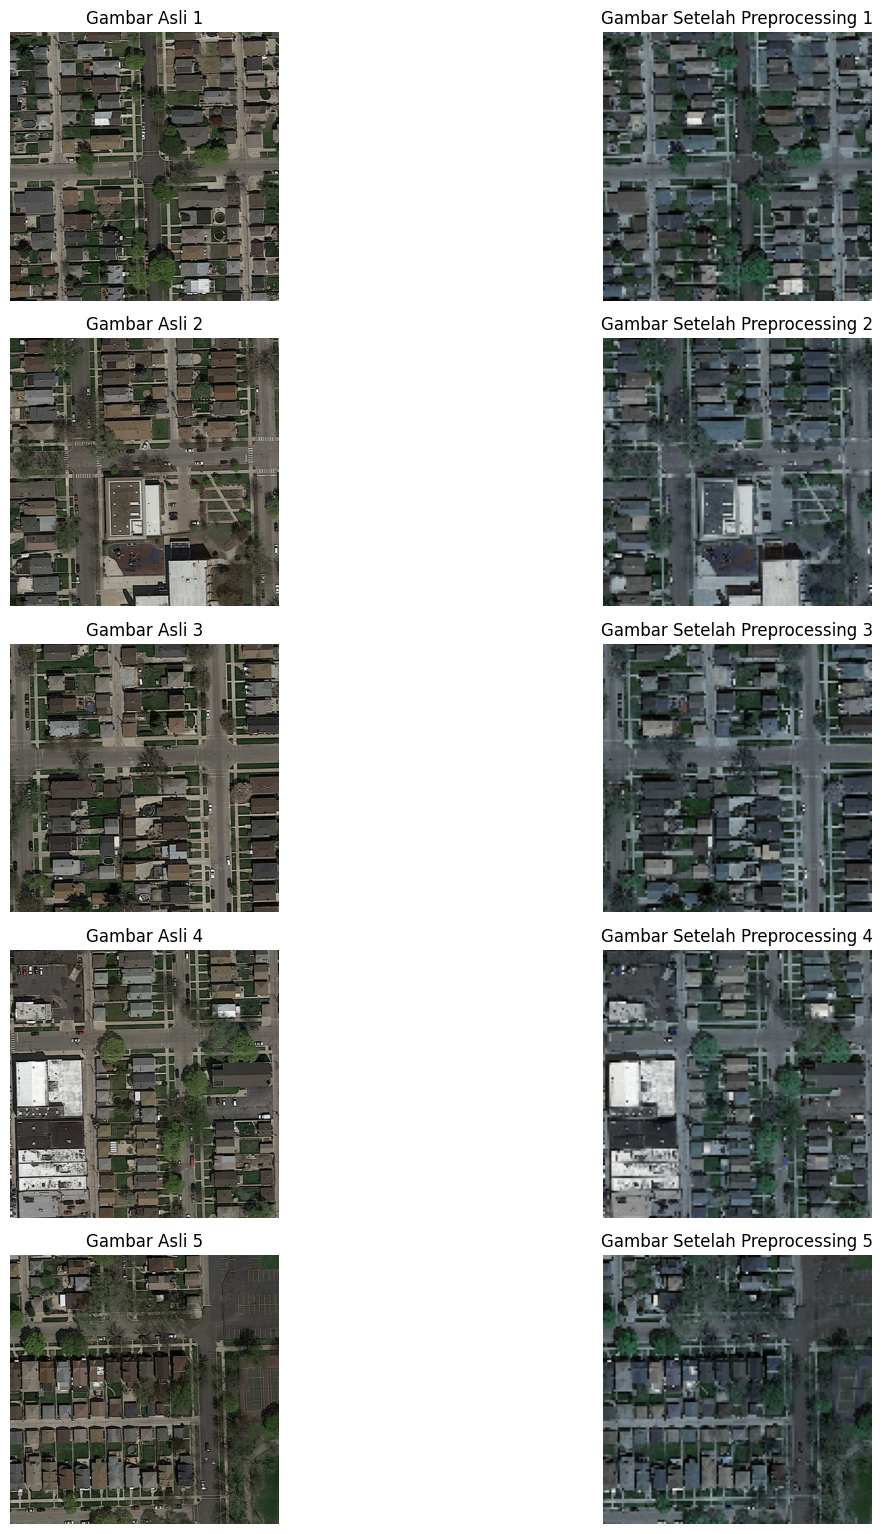

In [12]:
# Menampilkan gambar asli dan gambar setelah preprocessing
num_images = len(original_images)  # Jumlah gambar
plt.figure(figsize=(12, 6 * (num_images // 2 + 1)))  # Ukuran figure

# Loop untuk menampilkan gambar
for i in range(5):
    # Gambar Asli
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(original_images[i])
    plt.title(f'Gambar Asli {i + 1}')
    plt.axis('off')

    # Gambar Setelah Preprocessing
    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(processed_images[i])
    plt.title(f'Gambar Setelah Preprocessing {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [38]:
# Memproses semua gambar di folder dengan menambahkan ekstrak fitur
features = []
image_paths = []

for filename in os.listdir(image_folder):
    if filename.endswith('.png'):  # Pastikan hanya memproses file PNG
        image_path = os.path.join(image_folder, filename)
        processed_image = preprocess_image(image_path)
        feature = extract_combined_features(processed_image)
        features.append(feature)
        image_paths.append(image_path)

In [14]:
# Menampilkan beberapa fitur yang diekstraksi
print("Contoh Fitur Gabungan:", features[0])

Contoh Fitur Gabungan: [0.17423493 0.0069694  0.         ... 0.         0.         0.        ]


# fungsi untuk kmeans clustering

In [16]:
# Fungsi untuk menghitung jarak Euclidean antara dua titik
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Fungsi untuk menginisialisasi centroid secara acak
def initialize_centroids(X, k):
    # Randomly select k points as initial centroids from the dataset
    random_indices = np.random.choice(X.shape[0], size=k, replace=False)
    centroids = X[random_indices]
    return centroids

# Fungsi untuk melakukan assign setiap data point ke centroid terdekat
def assign_clusters(X, centroids):
    clusters = []
    for point in X:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        closest_centroid = np.argmin(distances)
        clusters.append(closest_centroid)
    return np.array(clusters)

# Fungsi untuk menghitung ulang posisi centroid berdasarkan mean dari poin-poin dalam cluster
def update_centroids(X, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster_points = X[clusters == i]
        new_centroid = cluster_points.mean(axis=0) if len(cluster_points) > 0 else np.zeros(X.shape[1])
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

# Fungsi utama K-Means clustering
def kmeans(X, k, max_iters=100):
    # Step 1: Inisialisasi centroid
    centroids = initialize_centroids(X, k)

    for i in range(max_iters):
        # Step 2: Assign setiap data point ke centroid terdekat
        clusters = assign_clusters(X, centroids)

        # Step 3: Update centroid berdasarkan mean dari cluster
        new_centroids = update_centroids(X, clusters, k)

        # Jika centroid tidak berubah, kita anggap konvergen
        if np.all(centroids == new_centroids):
            print(f"Converged after {i+1} iterations.")
            break

        # Update centroid untuk iterasi berikutnya
        centroids = new_centroids

    return clusters, centroids

In [40]:
# melihat ukuran dari setiap elemen dalam array features
for i, feature in enumerate(features):
    print(f"Shape of feature {i}: {np.shape(feature)}")

Shape of feature 0: (32900,)
Shape of feature 1: (32900,)
Shape of feature 2: (32900,)
Shape of feature 3: (32900,)
Shape of feature 4: (32900,)
Shape of feature 5: (32900,)
Shape of feature 6: (32900,)
Shape of feature 7: (32900,)
Shape of feature 8: (32900,)
Shape of feature 9: (32900,)
Shape of feature 10: (32900,)
Shape of feature 11: (32900,)
Shape of feature 12: (32900,)
Shape of feature 13: (32900,)
Shape of feature 14: (32900,)
Shape of feature 15: (32900,)
Shape of feature 16: (32900,)
Shape of feature 17: (32900,)
Shape of feature 18: (32900,)
Shape of feature 19: (32900,)
Shape of feature 20: (32900,)
Shape of feature 21: (32900,)
Shape of feature 22: (32900,)
Shape of feature 23: (32900,)
Shape of feature 24: (32900,)
Shape of feature 25: (32900,)
Shape of feature 26: (32900,)
Shape of feature 27: (32900,)
Shape of feature 28: (32900,)
Shape of feature 29: (32900,)
Shape of feature 30: (32900,)
Shape of feature 31: (32900,)
Shape of feature 32: (32900,)
Shape of feature 33:

In [42]:
# melakukan proses ke array features yaitu normalisasi dengan standardscaler dan reduksi dimensi dengan PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming `features` is your feature array, and you want to handle None values
features = np.array([[0 if val is None else val for val in feature] for feature in features])

# Normalize features **before** PCA
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)  # Normalize features

# Apply PCA after normalization
pca = PCA(n_components=5)  # Choose the number of components
features_reduced = pca.fit_transform(normalized_features)

# At this point, you don't need padding as PCA returns all features with the same length


In [43]:
# melakukan proses clustering ke dataset training
k = 3  # Jumlah cluster yang diinginkan
clusters, centroids = kmeans(features_reduced, k)  # Panggil fungsi kmeans


Converged after 5 iterations.


In [44]:
# menampilkan hasil clustering gambar dalam bentuk array
print("Cluster Assignments:", clusters)

Cluster Assignments: [1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 2 0 2 1 2 2 1 2 2 2 1 1
 2 1 2 1 2 2 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 2 2 1 1 1 2 1
 2 2 1 2 1 1 1 1 2 1 1 2 2 2 2 2 1 1 2 1 2 2 2 2 1 2]


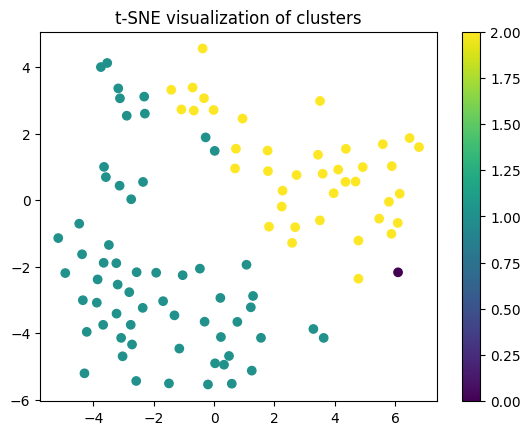

In [45]:
# menampilkan hasil clustering gambar dan distribusi nya dengan TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features_reduced)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('t-SNE visualization of clusters')
plt.show()


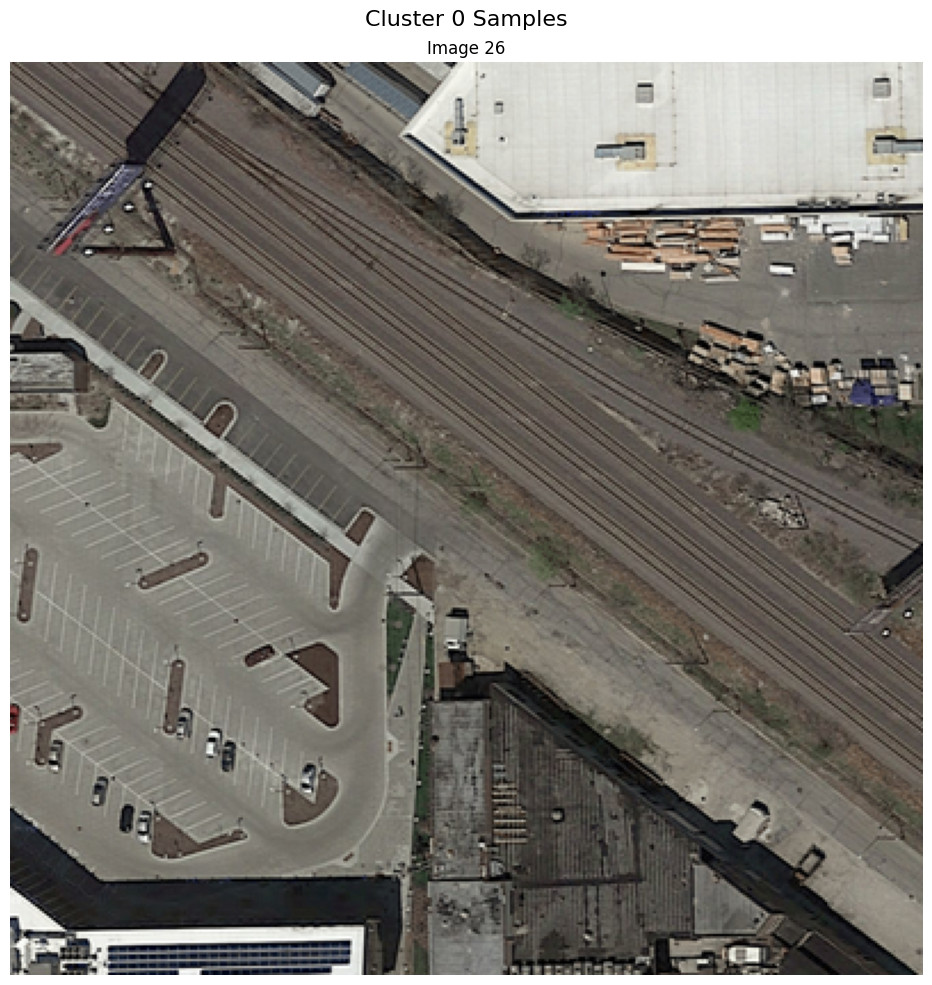

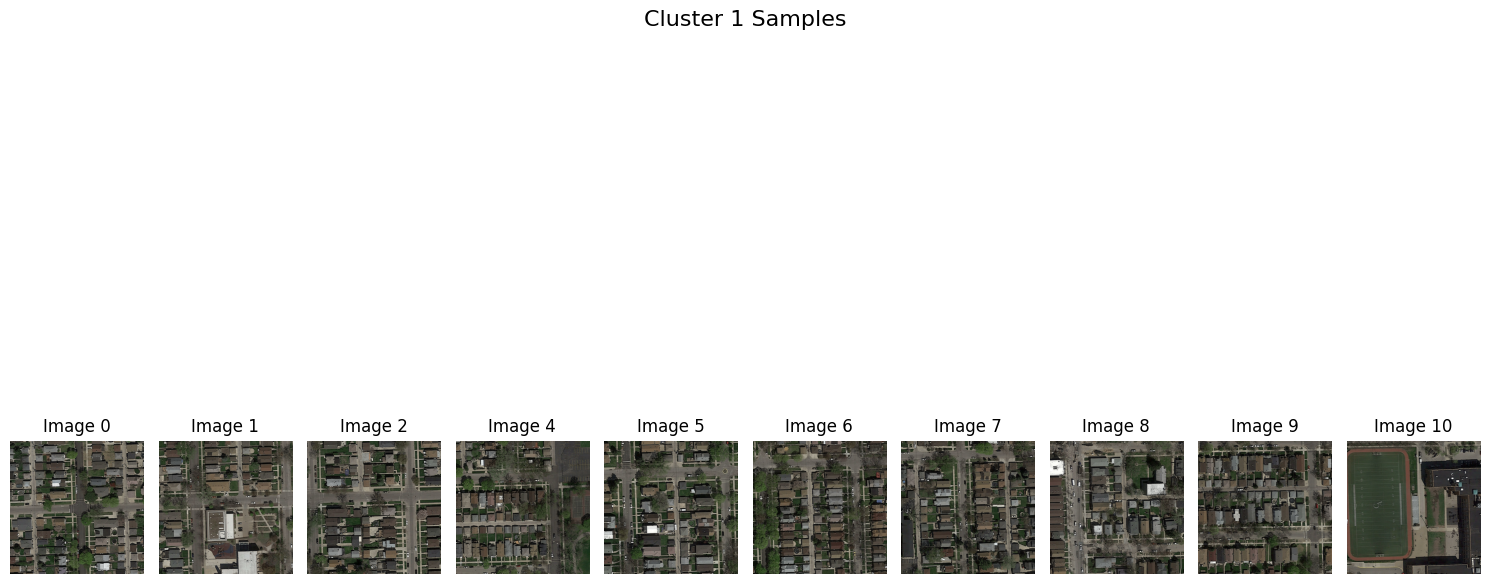

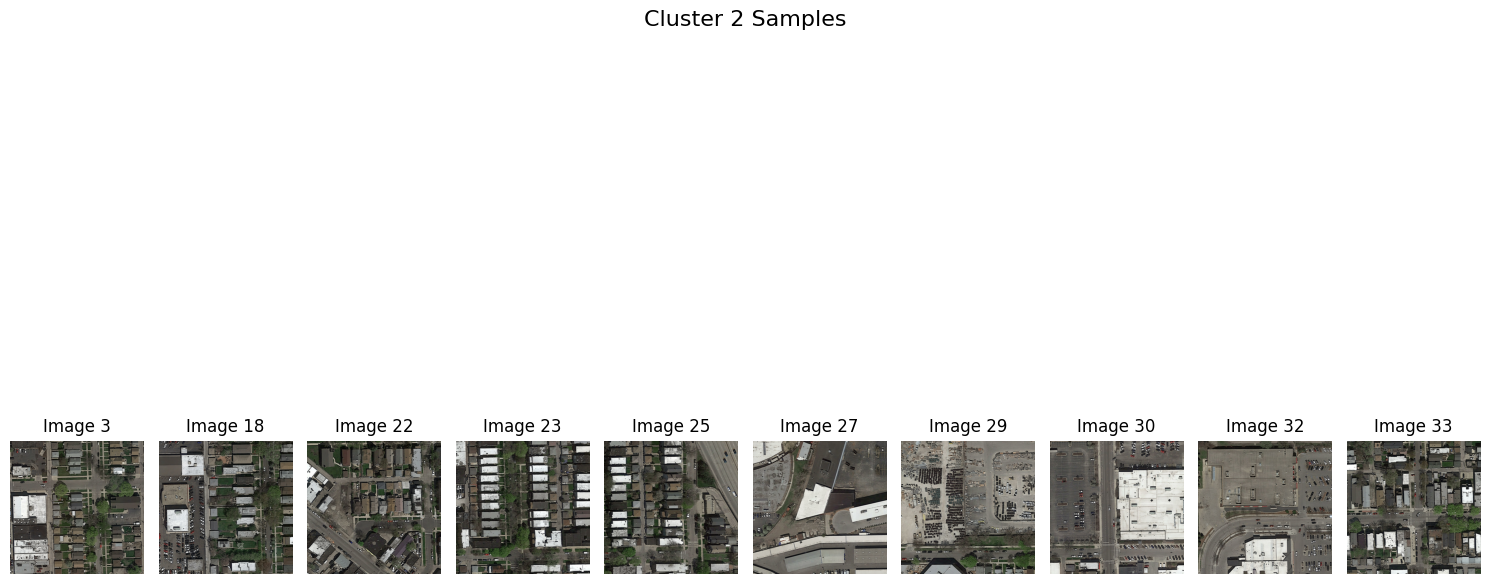

No images found for Cluster 3.


In [47]:
# menampilkan gambar-gambar yang masuk ke tiap-tiap cluster
def visualize_images_by_cluster(original_images, cluster_assignments, num_clusters, num_samples):
    # Loop through each cluster
    for cluster_num in range(num_clusters):
        # Get indices of images in the current cluster
        cluster_indices = [i for i, cluster in enumerate(cluster_assignments) if cluster == cluster_num]

        # Select up to num_samples images from the current cluster
        selected_indices = cluster_indices[:num_samples]

        # If there are fewer images than num_samples, adjust num_samples accordingly
        num_samples_actual = min(len(selected_indices), num_samples)

        # Skip visualization if there are no images in the current cluster
        if num_samples_actual == 0:
            print(f"No images found for Cluster {cluster_num}.")
            continue

        # Create subplots for the number of samples actually available
        fig, axes = plt.subplots(1, num_samples_actual, figsize=(15, 10))  # Create subplots with fig and axes
        fig.suptitle(f'Cluster {cluster_num} Samples', fontsize=16)  # Set suptitle for the figure

        # Ensure axes is a list, even when there's only one
        if num_samples_actual == 1:
            axes = [axes]  # Wrap in a list

        for i in range(num_samples_actual):
            img_index = selected_indices[i]  # Get index of selected image
            axes[i].imshow(original_images[img_index])  # Display original image on the corresponding subplot
            axes[i].set_title(f'Image {img_index}')
            axes[i].axis('off')  # Hide axes

        plt.tight_layout()  # Adjust subplot parameters for a tight layout
        plt.show()

# Visualize with more samples, for example, 10 samples per cluster
num_samples_to_show = 10  # Increase this value to see more samples
visualize_images_by_cluster(original_images, clusters, num_clusters=4, num_samples=num_samples_to_show)


In [48]:
# menyimpan model-model yang dibutuhkan
# model.pkl = clustering model
# scaler.pkl = scaler model
# pca.pkl = pca model
import joblib

# Assuming you have a trained model called 'model'
joblib.dump(model, 'model.pkl')  # Save model to a file
# Save the fitted scaler and PCA
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

['pca.pkl']

In [49]:
# melakukan evaluasi menggunakan silhouette score
from sklearn.metrics import silhouette_score

# Assuming `features` is a 2D array where each row corresponds to the feature vector of an image
# and `clusters` contains the cluster labels for each image.
silhouette_avg = silhouette_score(features_reduced, clusters)
print(f'Silhouette Coefficient: {silhouette_avg:.3f}')

Silhouette Coefficient: 0.300
